## Exercise Sheet 1: Recurrent Models

Compare Vanilla Recurrent Neural Networks (RNN) with Long-Short Term Networks (LSTM). Implement a vanilla RNN and LSTM from scratch. 

In [30]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import os
import time
import math
import sys
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.functional as F

# import RNN from torch
from torch.nn import RNN

import matplotlib.pyplot as plt
%matplotlib inline

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set paths
data_path = 'data/'
model_path = 'model/'
results_path = 'results/'

# make directories if they don't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)


# Hyperparameters 
config = {
    "input_length": 13,
    "input_dim": 1,
    "num_classes": 10,
    "num_hidden": 128,
    "batch_size": 128,
    "learning_rate": 0.001,
    "train_steps": 10000,
    "test_steps": 1000,
    "max_norm": 10.0
}

# save config
with open(model_path + 'config.json', 'w') as file:
    json.dump(config, file)

### Task 1: Toy Problem: Palindrome Numbers

Use a  a recurrent neural network to predict the next digit of the palindrome
at every timestep. This can become difficult for very long sequences since the network has to memorise information from very far away earlier timesteps. Goal is to study the memoization capability of recurrent networks.

In [31]:
class PalindromeDataset(data.Dataset):
    """ Randomly generates palindromes of a given length. 
        The input is the first N-1 digits of the palindrome, the target is the last digit.
        For short palindromes, the number of possible palindromes is limited.
    """
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))


In [32]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device=None):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.device = device

        # Define the RNN layer
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden, device=self.device)
        self.W_hx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))      # input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))     # hidden to hidden
        self.B_h = nn.Parameter(torch.Tensor(self.num_hidden))                       # hidden bias
        # Define the output layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))    # hidden to output
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))                      # output bias

        # Initialize weights
        self.init_weights()
    
    def forward(self, x):
        # Initialize hidden state
        h_t = torch.zeros(self.num_hidden)
            
        for t in range(self.seq_length): # iterate over the time steps
            x_t = x[:, t].view(128,-1)
            h_t = torch.tanh(x_t @ self.W_hx + h_t @ self.W_hh + self.B_h)
            
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        # Initialize weights
        nn.init.xavier_normal_(self.W_hx)
        nn.init.xavier_normal_(self.W_hh)
        nn.init.xavier_normal_(self.W_ph)
        nn.init.zeros_(self.B_h)
        nn.init.zeros_(self.B_y)
    
    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden, device=self.device)
    
    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [33]:
def compute_accuracy(outputs, targets):
    """ Compute the accuracy of the model's predictions."""
    # Compute accuracy of outputs compared to targets
    _, predicted = torch.max(outputs, 1)
    correct = predicted.eq(targets)
    return 100 * correct.sum().item() / targets.size(0)

In [40]:

def train(config:json, device=None):
    """ Train the model on the training set.
        Returns the trained model, losses and accuracies.
    """
    # Initialize the model that we are going to use
    model = VanillaRNN(config['input_length'], config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    model.train()
    
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(config['input_length'] + 1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    losses = []
    accuracies = []
    loss = 0.0

    for i, (inputs, targets) in enumerate(data_loader, 0):

        # Only for time measurement of step through network
        t1 = time.time()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])

        loss += loss.item()
        accuracy = 0.0

        # Print statistics
        if i % 10 == 0:
            # Just for time measurement
            t2 = time.time()
            # print accuracy/loss here
            accuracy = compute_accuracy(outputs, targets)
            accuracies.append(accuracy)
            print('[step: %5d] loss: %.4f acc: %.4f time: %5d' %
                          (i, loss / 10, accuracy, t2-t1 / 10))
            losses.append(loss.detach().numpy() / 10)
            loss = 0.0

        if i == config['train_steps']:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break
        
    print('Finished Training')
    return model, losses, accuracies


def test(model, config):
    """ Test the model on the test set.
        Returns the accuracies.
    """
    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(config['input_length']+1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    model.eval()

    # Test the model
    accuracies = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader, 0):
            outputs = model(inputs)
            accuracy = 0.0 
            if i % 10 == 0:
                accuracy = compute_accuracy(outputs, targets)
                accuracies.append(accuracy)
                print('Accuracy: %.4f' % accuracy)

            if i == config['test_steps']:
                break
            
    print('Finished Testing')
    return accuracies


In [35]:
# Load the configuration
with open(model_path + 'config.json', 'r') as file:
    config = json.load(file)

#### Train and evaluate model on Palindromes with length N = 11

In [36]:
# Train the model
model, losses, accuracies = train(config, device)

/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_40922/166680980.py:41: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:     0] loss: 0.4602 acc: 6.2500 time: 1547172670
[step:    10] loss: 0.4642 acc: 5.4688 time: 1547172670
[step:    20] loss: 0.4538 acc: 16.4062 time: 1547172670
[step:    30] loss: 0.4422 acc: 26.5625 time: 1547172670
[step:    40] loss: 0.4447 acc: 25.0000 time: 1547172670
[step:    50] loss: 0.4291 acc: 34.3750 time: 1547172670
[step:    60] loss: 0.4189 acc: 41.4062 time: 1547172670
[step:    70] loss: 0.4066 acc: 45.3125 time: 1547172670
[step:    80] loss: 0.4056 acc: 43.7500 time: 1547172670
[step:    90] loss: 0.3771 acc: 67.9688 time: 1547172670
[step:   100] loss: 0.3856 acc: 59.3750 time: 1547172670
[step:   110] loss: 0.3834 acc: 63.2812 time: 1547172670
[step:   120] loss: 0.3703 acc: 68.7500 time: 1547172670
[step:   130] loss: 0.3679 acc: 67.9688 time: 1547172670
[step:   140] loss: 0.3624 acc: 67.9688 time: 1547172670
[step:   150] loss: 0.3562 acc: 71.0938 time: 1547172670
[step:   160] loss: 0.3634 acc: 66.4062 time: 1547172670
[step:   170] loss: 0.3405 acc: 7

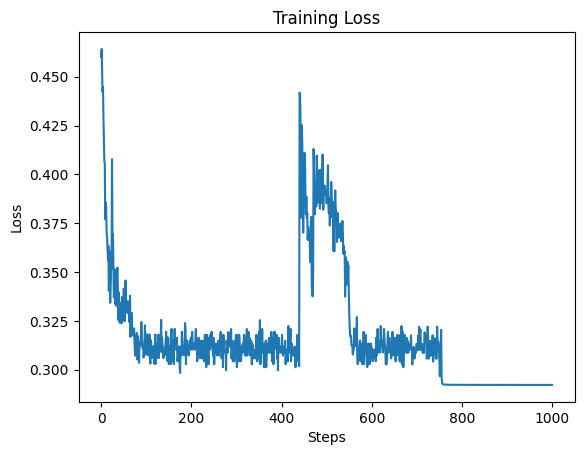

In [37]:
# Plot losses
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(results_path + 'training_loss.png')
plt.show()

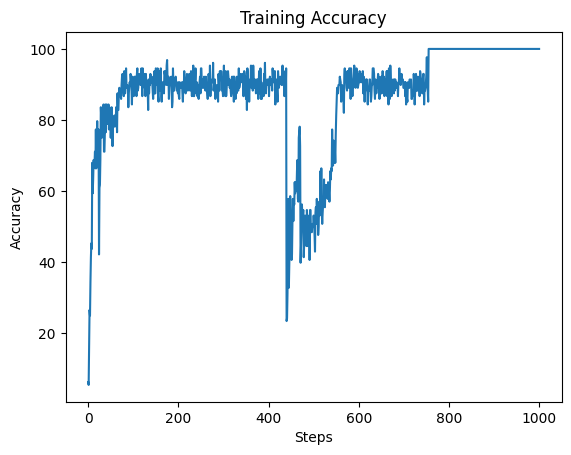

In [38]:
# Plot accuracies
plt.plot(accuracies)
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.savefig(results_path + 'training_accuracy.png')
plt.show()

In [41]:
# Test the model
test_accuracies = test(model, config)

Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 100.0000
Accuracy: 10

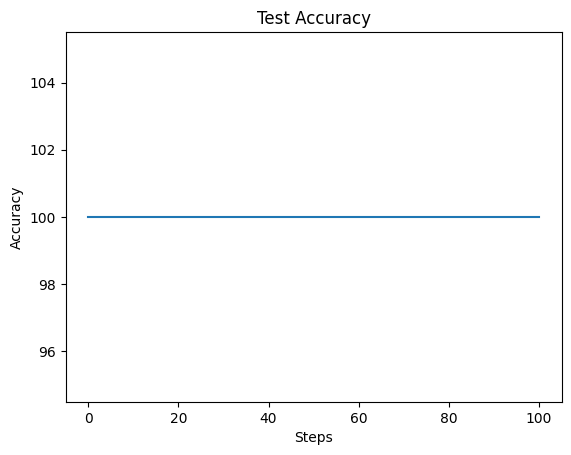

Average test accuracy: 100.00%


In [42]:
# Plot the loss curve
plt.plot(test_accuracies)
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.savefig(results_path + 'test_accuracy.png')
plt.show()

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 2: Vanilla RNN in PyTorch

### Task 3: Long-Short Term Network (LSTM) in PyTorch 